### Csuite data simulation testing template

In [1]:
# User
user = "nk1922"

# Imports
import torch
from torch import nn
from torch.distributions import Normal,Laplace,Uniform
import matplotlib.pyplot as plt
import os
import time
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

os.chdir('C:/Users/{0}/OneDrive/Documents/Cocycles project/Cocycle_code'.format(user))
from Cocycle_CDAGM import *
from Cocycle_model import *
from Cocycle_optimise import *
from Cocycle_loss_functions import *
from Conditioners import *
from Transformers import *
from KDE_estimation import *
from Kernels import *
from Helper_functions import *
os.chdir('C:/Users/{0}/OneDrive/Documents/Cocycles project/Experiments_code'.format(user))
from Csuite_CATE import Fork_Nonlin as DGP
from Csuite_CATE import Fork_conditioner as Conditioner
os.chdir('C:/Users/{0}/OneDrive/Documents/Cocycles project/Experimental_results'.format(user))

In [2]:
# Experimental set up
#parents = [[],[0],[1]]
parents = [[],[],[0,1],[2]]
trials = 1
N,Nint = 5000,10**6
int_levels = [0]
cate_levels = torch.linspace(-1,1,20)
intervention = lambda a,x : a+x*0
adversarial_distribution = True
gamma_param = 1

# Cocycle Estimation set up
cocycle_estimators = ["CLS_M", "CMMD_M_RFF","JMMD_M_RFF"]
RFF_features = [False,True,True]
n_RFF = [100,100,100]
median_heuristic = [False,True,True]

# RQS set up
RQS_bins = [2,4,8]

# MLE set up
Gaussian_SCM = True

# NN set up
train_val_split = 0.8
ntrain = int(train_val_split*N)
width = 128
layers = 2
conditioner_learn_rate = 1e-3
transformer_learn_rate = 1e-3
scheduler = True
val_tol = 1e-3
batch_size = 128
maxiter = 5000
miniter = 1000

# CE_setup
lr_reg = 0.05

# Samples to draw 
mc_samples = 10**5

In [3]:
# Names and dimensions
names = (["Gaussian SCM"]+
         ["RQS SCM {0}".format(i) for i in RQS_bins]+
         ["Cocycles {0}".format(i) for i in cocycle_estimators]+
         ["Cocycles {0} KRR".format(i) for i in cocycle_estimators]+
         ["Cocycles {0} NW".format(i) for i in cocycle_estimators]+
         #["Cocycles {0} LL".format(i) for i in cocycle_estimators]+
         ["True"])
n_model = len(names)
n_int = len(int_levels)
n_cate = len(cate_levels)

# Storage objects
CATE = torch.zeros((n_model,n_int,n_cate,trials))
Training_time = torch.zeros((n_model,trials))

# True model construction
true_models = []
for i in range(len(parents)):
    true_models.append(cocycle_model([Conditioner(i)],Shift_Transformer()))

In [4]:
# Initiating trials
for t in range(trials):
    
    torch.manual_seed(t)
    
    # Draw data
    Xobs,Xint = DGP(N, Nint, True, intervention, int_levels, adversarial_distribution, alpha = gamma_param)
    Xobs,Xobstest = Xobs[:N],Xobs[N:]

    # Draw CATE data
    Xobs_cate,Xint_cate = DGP(0, Nint, True, intervention, int_levels, adversarial_distribution, alpha = gamma_param,cate = True,cate_levels = cate_levels)
    
    # Estimate models
    ls_models = []
    cocycle_models = [[] for i in range(len(cocycle_estimators))]
    RQS_models = [[] for i in range(len(RQS_bins))]
    
    for i in range(len(parents)):
        
        # Getting relevant variables from graph
        index_x,index_y = parents[i],[i]
        X,Y = Xobs[:,index_x].view(N,len(index_x)),Xobs[:,index_y].view(N,len(index_y))
          
        # Data Preprocessing
        Xtrain,Ytrain,Xval,Yval = X[:ntrain],Y[:ntrain],X[ntrain:],Y[ntrain:]
        inputs_train,outputs_train, inputs_val,outputs_val = Xtrain,Ytrain,Xval,Yval

        # Defining and training Gaussian SCM
        if Gaussian_SCM:
            start_time = time.time()
            loss_fn = Loss(loss_fn = "MLE")
            if len(parents[i])>0:
                conditioner_shift = NN_Conditioner(width = width, layers = layers, input_dims =  len(index_x), output_dims = len(index_y) ,bias = True)
                conditioner_scale = Constant_Conditioner(init = torch.log(outputs_train.var()**0.5/2))
            else:
                conditioner_shift = Constant_Conditioner(init = outputs_train.mean())
                conditioner_scale = Constant_Conditioner(init = torch.log(outputs_train.var()**0.5))
            transformer = Affine_Transformer(log_det = True)
            ls_model = cocycle_model([conditioner_shift,conditioner_scale],transformer)
            ls_model = Train(ls_model).optimise(loss_fn,inputs_train,outputs_train,inputs_val,outputs_val, batch_size = batch_size,conditioner_learn_rate = conditioner_learn_rate,
                                                     transformer_learn_rate = transformer_learn_rate,print_ = True,plot = False, miniter = miniter,maxiter = maxiter, val_tol = val_tol,
                                               scheduler = scheduler)
            ls_model.transformer.ld = False # set log determinant to false after
            ls_models.append(ls_model)

            # Storing training time
            Training_time[0,t] +=  time.time() - start_time

        # Defining and training cocycle models
        if len(parents[i])>0:
            for m in range(len(cocycle_estimators)):
                start_time = time.time()
                loss_fn = Loss(loss_fn = cocycle_estimators[m],kernel = [gaussian_kernel(torch.ones(1),1),gaussian_kernel(torch.ones(1),1)])
                if RFF_features[m]:
                    loss_fn.get_RFF_features(n_RFF[m])
                if median_heuristic[m]:
                    loss_fn.median_heuristic(inputs_train,outputs_train, subsamples = 10**4)
                conditioner = NN_Conditioner(width = width, layers = layers, input_dims =  len(index_x), output_dims = len(index_y) ,bias = True)
                transformer = Shift_Transformer()
                model = cocycle_model([conditioner],transformer)
                model = Train(model).optimise(loss_fn,inputs_train,outputs_train,inputs_val,outputs_val, batch_size = batch_size,conditioner_learn_rate = conditioner_learn_rate,
                                                     transformer_learn_rate = transformer_learn_rate,print_ = True,plot = False, miniter = miniter,maxiter = maxiter, val_tol = val_tol,
                                             scheduler = scheduler)
                cocycle_models[m].append(model)
                
                end_time = time.time()

                Training_time[1+len(RQS_bins)+m,t] += end_time - start_time
                Training_time[1+len(RQS_bins)+len(cocycle_estimators)+m,t] += end_time - start_time
                Training_time[1+len(RQS_bins)+2*len(cocycle_estimators)+m,t] += end_time - start_time
                #Training_time[1+len(RQS_bins)+3*len(cocycle_estimators)+m,t] += end_time - start_time
        else:
            for m in range(len(cocycle_estimators)):
                cocycle_models[m].append([])

        # Defining and training RQS flow models
        start_time = time.time()
        loss_fn = Loss(loss_fn = "MLE")
        for m in range(len(RQS_bins)):
            if len(parents[i])>0:
                conditioner = NN_Conditioner(width = width, layers = layers, input_dims =  len(index_x), output_dims = len(index_y) ,bias = True)
            else:
                conditioner = Empty_Conditioner()
            transformer =  RQS_Shift_Transformer(widths = torch.zeros((1,RQS_bins[m]),requires_grad = True),
                                   heights = torch.zeros((1,RQS_bins[m]), requires_grad = True),
                                   derivatives = torch.zeros((1,RQS_bins[m]+1), requires_grad = True)
                                   )
            RQS_model = cocycle_model([conditioner],transformer)
            RQS_model = Train(RQS_model).optimise(loss_fn,inputs_train,outputs_train,inputs_val,outputs_val, batch_size = batch_size,conditioner_learn_rate = conditioner_learn_rate,
                                                     transformer_learn_rate = transformer_learn_rate,print_ = True,plot = False, miniter = miniter,maxiter = maxiter, val_tol = val_tol,
                                                 scheduler = scheduler)
            RQS_model.transformer.ld = False # set log determinant to false after
            RQS_models[m].append(RQS_model)

            Training_time[1+m,t] += time.time() - start_time
    
    # Defining cocycle CDAGMs
    ccdagm = []
    for m in range(len(cocycle_estimators)):
        ccdagm.append(CCDAGM(cocycle_models[m],parents))

    # Interventional prediction
    print(t)
    for i in range(len(int_levels)):
        
        # Setting intervention level
        a = int_levels[i]
        
        # Regression estimation for cocycles
        KRR_models,KRR_models_int = [],[]
        NW_models,NW_models_int = [],[]
        LL_models = []
        X_cocycle,Xint_cocycle = [],[]
        for m in range(len(cocycle_estimators)):
            
            # Getting inter,ventional samples
            Xpred,Xintpred = ccdagm[m].interventional_dist_sample(Xobs,intervention,["id",a,"id","id"],len(Xobs),uniform_subsample = False)
            X_cocycle.append(Xpred.detach())
            Xint_cocycle.append(Xintpred.detach())
        
            # KRR
            start_time = time.time()
            KRR_regressor_int = KRR_functional(gaussian_kernel(lengthscale = torch.ones(1,requires_grad = True)))
            CE_KRR_int = Conditional_Expectation_Regressor(KRR_regressor_int)
            losses = CE_KRR_int.optimise(Xpred[:,:1],Xintpred[:,-1:]-Xpred[:,-1:],learn_rate = lr_reg)
            Training_time[1+len(RQS_bins)+len(cocycle_estimators)+m,t] += time.time() - start_time
            KRR_models.append(CE_KRR_int)
            KRR_models_int.append(CE_KRR_int)
            
            # NW
            start_time = time.time()
            NW_regressor_int = NW_functional(gaussian_kernel(lengthscale = torch.ones(1,requires_grad = True)))
            CE_NW_int = Conditional_Expectation_Regressor(NW_regressor_int)
            losses = CE_NW_int.optimise(Xpred[:,:1],Xintpred[:,-1:]-Xpred[:,-1:],learn_rate = lr_reg)
            Training_time[1+len(RQS_bins)+len(cocycle_estimators)+m,t] += time.time() - start_time
            NW_models.append(CE_NW_int)
            NW_models_int.append(CE_NW_int)
            
            # LL
            #start_time = time.time()
            #LL_regressor_int = LL_functional(gaussian_kernel(lengthscale = torch.ones(1,requires_grad = True)))
            #CE_LL_int = Conditional_Expectation_Regressor(LL_regressor_int)
            #losses = CE_LL_int.optimise(Xpred[:,:1],Xintpred[:,-1:]-Xpred[:,-1:],learn_rate = lr_reg)
            #Training_time[1+len(RQS_bins)+len(cocycle_estimators)+m,t] += time.time() - start_time
            #LL_models.append(CE_LL_int)
            #LL_models_int.append(CE_LL_int)
        
        # Getting CATE samples
        for c in range(len(cate_levels)):
            z = cate_levels[c]
            Xpred = [],[]
            for m in range(n_model):
                if m == 0 and Gaussian_SCM:
                    x,Xpred = SCM_intervention_sample(parents,ls_models,[Normal(0,1)]*len(parents),intervention,[[z,"id","id","id"]],mc_samples)
                    x,Xintpred = SCM_intervention_sample(parents,ls_models,[Normal(0,1)]*len(parents),intervention,[[z,a,"id","id"]],mc_samples)
                    Xdiff = (Xintpred[0][:,-1]-Xpred[0][:,-1]).detach()
                elif m > 0 and m <= len(RQS_bins):
                    x,Xpred = SCM_intervention_sample(parents,RQS_models[m-1],[Normal(0,1)]*len(parents),intervention,[[z,"id","id","id"]],mc_samples)
                    x,Xintpred = SCM_intervention_sample(parents,RQS_models[m-1],[Normal(0,1)]*len(parents),intervention,[[z,a,"id","id"]],mc_samples)
                    Xdiff = (Xintpred[0][:,-1]-Xpred[0][:,-1]).detach()
                elif m > len(RQS_bins) and m <= len(RQS_bins)+len(cocycle_estimators):
                    x,Xpred = ccdagm[m-len(RQS_bins)-1].interventional_dist_sample(Xobs,intervention,[z,"id","id","id"],len(Xobs),uniform_subsample = False)
                    x,Xintpred = ccdagm[m-len(RQS_bins)-1].interventional_dist_sample(Xobs,intervention,[z,a,"id","id"],len(Xobs),uniform_subsample = False)
                    Xdiff = (Xintpred[:,-1]-Xpred[:,-1]).detach()
                elif m > len(RQS_bins)+len(cocycle_estimators) and m <= len(RQS_bins)+2*len(cocycle_estimators):
                    m_c = m-len(RQS_bins)-len(cocycle_estimators)-1
                    Xdiff = (KRR_models_int[m_c].forward(Xint_cocycle[m_c][:,-1:],X_cocycle[m_c][:,:1],torch.tensor([[z]]))-
                            KRR_models[m_c].forward(X_cocycle[m_c][:,-1:],X_cocycle[m_c][:,:1],torch.tensor([[z]]))).detach()
                elif m > len(RQS_bins)+2*len(cocycle_estimators) and m <= len(RQS_bins)+3*len(cocycle_estimators):
                    m_c = m-len(RQS_bins)-2*len(cocycle_estimators)-1
                    Xdiff = (NW_models_int[m_c].forward(Xint_cocycle[m_c][:,-1:],X_cocycle[m_c][:,:1],torch.tensor([[z]]))-
                            NW_models[m_c].forward(X_cocycle[m_c][:,-1:],X_cocycle[m_c][:,:1],torch.tensor([[z]]))).detach()
                    #elif m > len(RQS_bins)+3*len(cocycle_estimators) and m <= len(RQS_bins)+4*len(cocycle_estimators):
                #    m_c = m-len(RQS_bins)-3*len(cocycle_estimators)-1
                #    Xdiff = LL_models[m_c].forward(Xint_cocycle[m_c][:,-1:]-X_cocycle[m_c][:,-1:],X_cocycle[m_c][:,:1],torch.tensor([[z]])).detach()
                else:
                    Xpred,Xintpred = Xobs_cate[c],Xint_cate[c][i]
                    Xdiff = Xintpred[:,-1]-Xpred[:,-1]
        
                                  
                CATE[m,i,c,t] = Xdiff.mean()

Training loss last 10 avg is : tensor(1.0357)
Validation loss last 10 avg is : tensor(1.0483)
Completion % : 19.82
0
iter 0 , loss =  tensor(11.0368)
iter 10 , loss =  tensor(10.5709)
iter 20 , loss =  tensor(10.5686)
iter 30 , loss =  tensor(10.5636)
iter 40 , loss =  tensor(10.5550)
iter 50 , loss =  tensor(10.5515)
iter 60 , loss =  tensor(10.5508)
iter 70 , loss =  tensor(10.5505)
iter 80 , loss =  tensor(10.5505)
iter 90 , loss =  tensor(10.5505)
iter 100 , loss =  tensor(10.5503)
iter 110 , loss =  tensor(10.5503)
iter 120 , loss =  tensor(10.5503)
iter 130 , loss =  tensor(10.5503)
iter 0 , loss =  tensor(10.7524)
iter 10 , loss =  tensor(10.5641)
iter 20 , loss =  tensor(10.5706)
iter 30 , loss =  tensor(10.5701)
iter 40 , loss =  tensor(10.5655)
iter 50 , loss =  tensor(10.5639)
iter 60 , loss =  tensor(10.5642)
iter 70 , loss =  tensor(10.5639)
iter 80 , loss =  tensor(10.5640)
iter 90 , loss =  tensor(10.5639)
iter 0 , loss =  tensor(11.7214)
iter 10 , loss =  tensor(11.3967

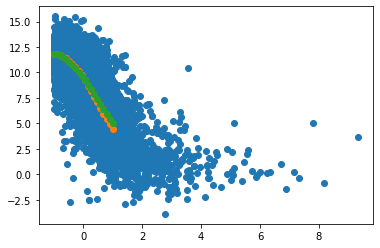

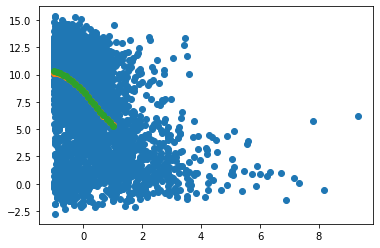

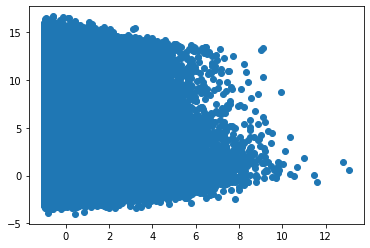

In [5]:
plt.scatter(X_cocycle[0][:,:1].T,Xint_cocycle[0][:,-1:].T)
xmeans = torch.zeros(len(cate_levels))
for i in range(len(cate_levels)):
    xmeans[i] = Xint_cate[i][0][:,-1].mean()
plt.scatter(cate_levels,xmeans)
plt.scatter(cate_levels,KRR_models_int[0].forward(Xint_cocycle[0][:,-1:],X_cocycle[0][:,:1],cate_levels.view(len(cate_levels),1)).detach())
plt.show()
plt.scatter(X_cocycle[0][:,:1].T,X_cocycle[0][:,-1:].T)
xmeans = torch.zeros(len(cate_levels))
for i in range(len(cate_levels)):
    xmeans[i] = Xobs_cate[i][:,-1].mean()
plt.scatter(cate_levels,xmeans)
plt.scatter(cate_levels,KRR_models[0].forward(X_cocycle[0][:,-1:],X_cocycle[0][:,:1],cate_levels.view(len(cate_levels),1)).detach())
plt.show()
plt.scatter(Xobstest[:,:1].T,Xobstest[:,-1:].T)
plt.show()

In [5]:
# Saving output
os.chdir('C:/Users/{0}/OneDrive/Documents/Cocycles project'.format(user))
torch.save({ "names": names, 
            "CATE (models x int_levels x cate_levels trials)": CATE,
            "Training time (models x trials)": Training_time
           },
           f = f'Experimental_results/'+'Test_CATE_adversarial={0}_trials={1}_gamma_param={2}_batchsize={3}.pt'.format(adversarial_distribution,trials, gamma_param,batch_size))

In [6]:
# Fork Gauss
ints = torch.linspace(0,19,20).int()
for i in range(n_model):
    print ((torch.abs(CATE[i,0,ints,:t+1]-CATE[-1,0,ints,:t+1])**2).mean(), names[i])

tensor(1.0618) Gaussian SCM
tensor(0.3830) RQS SCM 2
tensor(0.1026) RQS SCM 4
tensor(0.1270) RQS SCM 8
tensor(0.0513) Cocycles CLS_M
tensor(0.0465) Cocycles CMMD_M_RFF
tensor(0.0183) Cocycles JMMD_M_RFF
tensor(0.0623) Cocycles CLS_M KRR
tensor(0.0655) Cocycles CMMD_M_RFF KRR
tensor(0.0155) Cocycles JMMD_M_RFF KRR
tensor(0.1035) Cocycles CLS_M NW
tensor(0.0951) Cocycles CMMD_M_RFF NW
tensor(0.0171) Cocycles JMMD_M_RFF NW
tensor(0.) True


In [ ]:
# NonlinGauss Gauss
ints = [0,1,2,3,4]
for i in range(n_model):
    print ((torch.abs(ATE[i,ints,:t+1]-ATE[-1,ints,:t+1])**2).mean(1)**0.5, names[i])

In [ ]:
# Fork adverse 1
ints = [0,1,2,3,4]
for i in range(n_model):
    print ((torch.abs(ATE[i,ints,:t+1]-ATE[-1,ints,:t+1])**2).mean(1)**0.5, names[i])

In [ ]:
# NonlinG adverse 1
ints = [0,1,2,3,4]
for i in range(n_model):
    print ((torch.abs(ATE[i,ints,:t+1]-ATE[-1,ints,:t+1])**2).mean(1)**0.5, names[i])